# BCI-Motor imagery Data Preprocessing

1. Import data and check stimulus

In [23]:
import mne
raw_edf = mne.io.read_raw_edf("C:\git\Senior_Thesis\DataSet\Convert_data\class3_try_edf.edf",preload = True)

Extracting EDF parameters from C:\git\Senior_Thesis\DataSet\Convert_data\class3_try_edf.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 107749  =      0.000 ...   430.996 secs...
Extracting EDF parameters from C:\git\Senior_Thesis\DataSet\Convert_data\class3_try2_edf.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 107749  =      0.000 ...   430.996 secs...


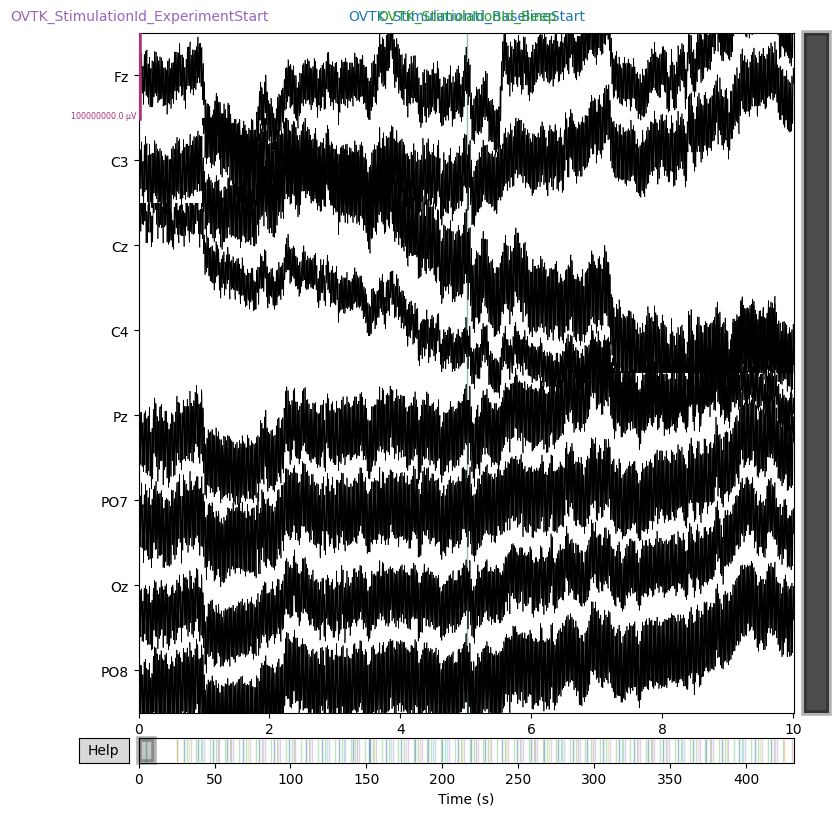

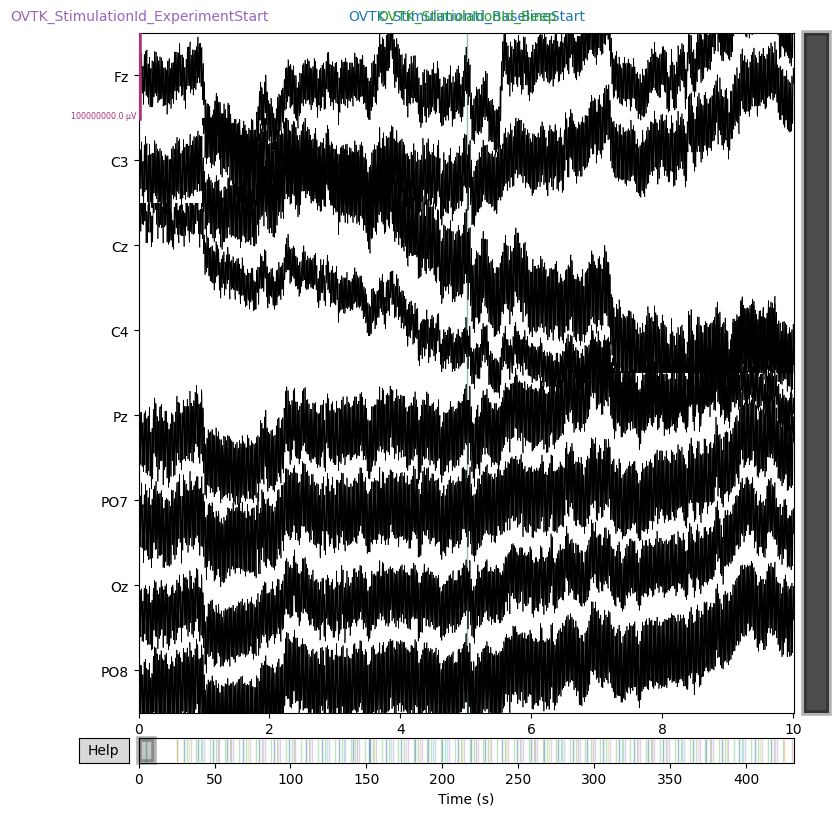

In [24]:
raw_edf.plot(
    duration=10, 
    start=0.0, 
    scalings=50, # You may edit scalings value later
    )

In [26]:
raw_eeg = raw_edf.pick_channels(['C3','Cz','C4'])
events, event_dict = mne.events_from_annotations(raw_eeg)
print('Total events:', len(events))

Used Annotations descriptions: ['OVTK_GDF_Cross_On_Screen', 'OVTK_GDF_End_Of_Session', 'OVTK_GDF_End_Of_Trial', 'OVTK_GDF_Feedback_Continuous', 'OVTK_GDF_Left', 'OVTK_GDF_Right', 'OVTK_GDF_Start_Of_Trial', 'OVTK_GDF_Tongue', 'OVTK_GDF_Up', 'OVTK_StimulationId_BaselineStart', 'OVTK_StimulationId_BaselineStop', 'OVTK_StimulationId_Beep', 'OVTK_StimulationId_ExperimentStart', 'OVTK_StimulationId_Train']
Total events: 247
